In [1]:
import os
from typing import Dict, List, Tuple
import json
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
import numpy as np
import fire

import torch
import torch.nn as nn

import sklearn.gaussian_process as gp

from bayesian_optimization import BayesianOptimization

from super_resolution import super_resolution
from denoising import denoising
from inpainting import inpainting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
seed = 11
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
trials = 10
minimize = True
num_iter_eval_fn = 10
criterion = 'mse'
metric = "psnr_gt_sm"
img_name = "mri0"
task = 'super_resolution'
config = "configs/bo_prior_sigma"
save = False
save_trials = False
log_dir = "/media/fastdata/toelle/logs_del"
gpu = 1

In [3]:
with open(config + ".json") as f:
    config = json.load(f)

NET_SPECS = config["net_specs"]
OPTIM_SPECS = config["optim_specs"]

if task == "denoising":
    fn = denoising
elif task == "super_resolution":
    fn = super_resolution
elif task == "inpainting":
    fn = inpainting

In [4]:
def eval_fn(params: Dict[str, float]) -> Dict[str, Tuple[float]]:
    for p_name, p_val in params.items():
        if p_name in config["optim_params"]:
            OPTIM_SPECS[p_name] = p_val
        else:
            NET_SPECS[p_name] = p_val

    results = fn(img_name=img_name,
                 num_iter=num_iter_eval_fn,
                 criterion=criterion,
                 net_specs=NET_SPECS,
                 optim_specs=OPTIM_SPECS,
                 save=save_trials,
                 path_log_dir=log_dir,
                 gpu=gpu,
                 seed=seed) # torch.randint(1000, (1,)).item())

    res = results[metric][-int(0.1*num_iter_eval_fn):]
    return [np.mean(res)]

HR and LR resolutions: (448, 512), (112, 128)


I: 10 | ELBO: 2.44 | PSNR_LR: 14.97 | PSNR_HR: 14.78 | PSNR_HR_gt_sm: 6.93: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

HR and LR resolutions: (448, 512), (112, 128)


I: 10 | ELBO: 2.05 | PSNR_LR: 15.06 | PSNR_HR: 14.88 | PSNR_HR_gt_sm: 6.94: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

HR and LR resolutions: (448, 512), (112, 128)


I: 10 | ELBO: 2.57 | PSNR_LR: 17.24 | PSNR_HR: 16.92 | PSNR_HR_gt_sm: 6.91: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

HR and LR resolutions: (448, 512), (112, 128)


I: 10 | ELBO: 3.10 | PSNR_LR: 17.04 | PSNR_HR: 16.70 | PSNR_HR_gt_sm: 6.90: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

Training GP...
loss: 28.752 | lengthscale: 0.129 | noise: 0.19544:   1%|          | 10/1000 [00:00<00:11, 89.91it/s]

loss: 6.071 | lengthscale: 2.369 | noise: 0.00025: 100%|██████████| 1000/1000 [00:10<00:00, 91.65it/s]
HR and LR resolutions: (448, 512), (112, 128)


I: 10 | ELBO: 3.31 | PSNR_LR: 16.40 | PSNR_HR: 16.15 | PSNR_HR_gt_sm: 6.92: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


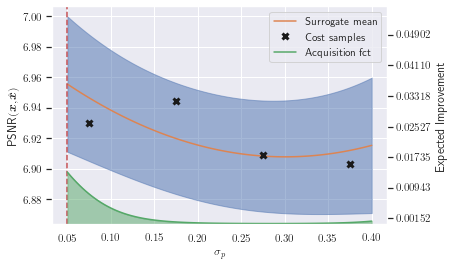

Training GP...
loss: 4.540 | lengthscale: 2.512 | noise: 0.00031: 100%|██████████| 1000/1000 [00:10<00:00, 91.49it/s]
HR and LR resolutions: (448, 512), (112, 128)


I: 10 | ELBO: 3.32 | PSNR_LR: 16.38 | PSNR_HR: 16.13 | PSNR_HR_gt_sm: 6.92: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


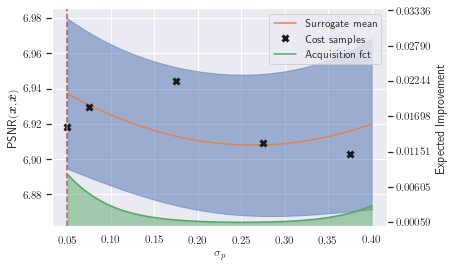

Training GP...
loss: 3.344 | lengthscale: 2.586 | noise: 0.00023:  64%|██████▍   | 644/1000 [00:06<00:03, 92.39it/s]


KeyboardInterrupt: 

In [5]:
params = {p["name"]: p["bounds"] for p in config["parameter"]}

initial_params_vals = config["initial_parameter"] if "initial_parameter" in config.keys() else None

acq_kwargs = {"xi": 0.001}

bayesian_optimization = BayesianOptimization(
    params=params,
    initial_params_vals=initial_params_vals,
    n_init=2,
    obj_fn=eval_fn,
    acq_fn='expected_improvement',
    acq_kwargs=acq_kwargs
)

lengthscale_prior = dict(concentration=0.1, rate=1.5)
lengthscale_constraint = 0.05
mean_prior = dict(loc=25., scale=2.)
noise_prior = dict(concentration=1e-2, rate=100.)
#noise_prior = 1e-4

best_params = bayesian_optimization.optimize(trials=trials, plot=True, lengthscale_prior=lengthscale_prior, lengthscale_constraint=lengthscale_constraint, 
                                             mean_prior=mean_prior, noise_prior=noise_prior, num_iter_gp=1000)

print(best_params)